In [1]:
import numpy as np
import os
import math
import pandas as pd
from collections import Counter
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import one_hot
from confusion_matrix import print_confusion_matrix

In [3]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [4]:
main_path_word_emb = "C:/Users/svruchtel/Documents/1/Texts classification/LSTM_results_word_emb/"
main_path_char_emb = "C:/Users/svruchtel/Documents/1/Texts classification/LSTM_results_char_emb/"

In [5]:
y_train = np.load("C:/Users/svruchtel/Documents/1/Images Classification/images_stacking/VGG16_y_train_USA.npy")
y_test = np.load("C:/Users/svruchtel/Documents/1/Images Classification/images_stacking/VGG16_y_test_USA.npy")

In [6]:
print(y_train.shape)
print(y_test.shape)

(5531,)
(622,)


In [11]:
# for idx in range(len(y_train_2nd_net_word_emb)):
#     if y_train_2nd_net_word_emb[0].any() != y_train_3rd_net_word_emb[0].any():
#         print("problem")

In [12]:
# for idx in range(len(y_train_word_emb)):
#     if y_train_word_emb[0].any() != y_train_word_emb[0].any():
#         print("problem")

In [7]:
# let's load what we need
X_train_3rd_net_word_emb = np.load(main_path_word_emb + "USA_3rd_net_train_X_GLOVE.EN.npy")
X_test_3rd_net_word_emb = np.load(main_path_word_emb + "USA_3rd_net_test_X_GLOVE.EN.npy")

X_train_3rd_net_char_emb = np.load(main_path_char_emb + "USA_3rd_net_train_X_100_chars_GLOVE.EN.npy")
X_test_3rd_net_char_emb = np.load(main_path_char_emb + "USA_3rd_net_test_X_100_chars_GLOVE.EN.npy")

In [8]:
CATEGORIES_COUNT = 11

In [9]:
X_train_3_3 = np.concatenate((X_train_3rd_net_word_emb, X_train_3rd_net_char_emb), axis=1)
X_test_3_3 = np.concatenate((X_test_3rd_net_word_emb, X_test_3rd_net_char_emb), axis=1)

In [10]:
print(X_train_3_3.shape)
print(X_test_3_3.shape)

(5531, 22)
(622, 22)


In [11]:
y_train = one_hot(y_train, CATEGORIES_COUNT)
y_test = one_hot(y_test, CATEGORIES_COUNT)

In [12]:
y_train.shape

(5531, 11)

In [13]:
y_test.shape

(622, 11)

#### 3 word, 3 char

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               11776     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 11)                2827      
Total params: 145,931
Trainable params: 145,931
Non-trainable params: 0
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 2s 374us/step - loss: 0.466

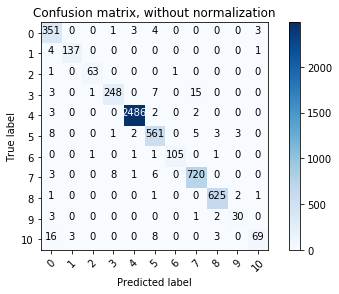

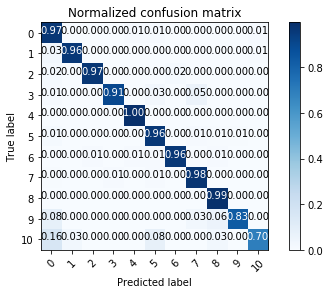


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 41   0   0   0   0   0   0   0   0   0   0]
 [  2  11   0   0   0   0   2   0   0   0   1]
 [  0   0   7   0   0   0   1   0   0   0   0]
 [  0   0   0  17   0   1   0  13   0   0   0]
 [ 35   1   0   0 223   9   0  10   0   0   0]
 [ 12   0   0   4   2  35   0   9   1   0   2]
 [  1   0   0   0   0   1  11   0   0   0   0]
 [  0   0   0   4   0   4   0  75   0   0   0]
 [  1   0   0   1   0   0   1   0  66   1   1]
 [  0   0   0   0   0   0   2   0   0   1   1]
 [  0   5   0   0   0   1   1   1   1   0   3]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.125      0.6875     0.         0.         0.         0.
  0.125      0.         0.         0.         0.0625    ]
 [0.         0.         0.875      0.         0.         0.
  0.125      0.         0.         0.         0.        ]
 [0.         0.         0.         0.

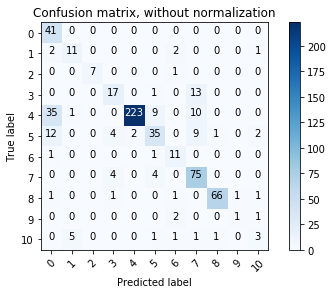

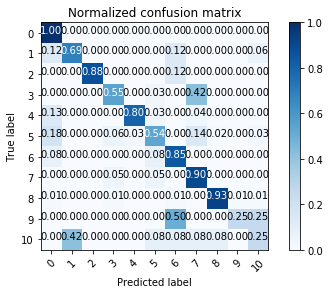

Wall time: 14.5 s


In [16]:
%%time
categories_count = CATEGORIES_COUNT

X_train = X_train_3_3
X_test = X_test_3_3

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=X_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto')
history_callback = meta_net.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                epochs=300, batch_size=100, callbacks=[callback])

test_scores = meta_net.evaluate(X_test, y_test, verbose=0)
    
print("test accuracy:  %.4f" % test_scores[1])
print("")

y_train_pred = (meta_net.predict(X_train).round()).argmax(axis=1)
y_test_pred = (meta_net.predict(X_test).round()).argmax(axis=1)

print("TRAIN CONFUSION MATRIX")
print_confusion_matrix(X_train, (y_train.round()).argmax(axis=1), y_train_pred, categories_count=CATEGORIES_COUNT)

print("")
print("TEST CONFUSION MATRIX")
print_confusion_matrix(X_test, (y_test.round()).argmax(axis=1), y_test_pred, categories_count=CATEGORIES_COUNT)

# and than write results info files
file_path_train = "./Stacking_Results_USA/meta_net_train_3_3_GLOVE_EN_ALL.npy"
file_path_test = "./Stacking_Results_USA/meta_net_test_3_3_GLOVE_EN_ALL.npy"

In [20]:
y_train_pred = meta_net.predict(X_train)
y_test_pred = meta_net.predict(X_test)

np.save(file_path_train, y_train_pred)
np.save(file_path_test, y_test_pred)

In [19]:
print("Result test accuracy:  %.4f" % test_scores[1])

Result test accuracy:  0.7942
